W4-method : a new multi-dimensional root-finding scheme for nonlinear
systems of equations

Okawa et al. arXiv:1809.04495v1

https://arxiv.org/abs/1809.04495v1

Fujisawa et al. (ApJ, 2019) arXiv:1809.04358

https://arxiv.org/abs/1809.04358

https://ui.adsabs.harvard.edu/abs/2019ApJ...872..155F/abstract


In [1]:
from scipy.optimize import newton
from scipy.linalg import lu, inv
from numpy import cosh, zeros_like, mgrid, zeros, sin, cos, pi
import numpy as np
import scipy as sci

In [2]:
#Fujisawa problem (Eqs. (50a,b) in Okawa et al.)
def fjsw(x):
    fx = np.zeros(2)
    fx[0] = x[0]**2 + x[1]**2 - 4.0
    fx[1] = x[0]**2*x[1] - 1.0 
    return fx

In [3]:
#deribative of diagonal component
def fp(x,f, eps = 1.0e-8):
    df_dx = zeros_like(x)
    x1    = zeros_like(x)
    ndim  = x1.shape[0]
    for i in range(ndim):
        x1[:] = x[:]
        x1[i]+= eps
        df_dx[i] = (f(x1)[i] - f(x)[i]) / eps
    
    return df_dx

#numerical Jacobian
def Jac_num(x, f, eps = 1.0e-8):
    x1    = zeros_like(x)
    ndim  = x1.shape[0]
    Jac   = np.zeros((ndim,ndim))
    for i in range(ndim):
        x1[:] = x[:]
        x1[i]+= eps
        Jac[0:ndim,i] = (f(x1) - f(x)) / eps
    
    return Jac




In [4]:
def dW4(f, x, maxiter=1000, tol = 1.0e-10, dtau = 0.5):
    p = zeros_like(x)
    ndim = print(p.shape[0])
    x0= zeros_like(x)
    x1= zeros_like(x)
    fxp= zeros_like(x)    
    ite = 0
    x0  = x
    while(True):
        ite += 1
        if(ite>maxiter) :
            print("Not Converge")
            return x0
        
        x1 = x0 + dtau * p/fp(x0, f) 
        p  = (1.0-2.0*dtau) * p - f(x0) *  dtau 

        x0 = x1
        error = abs(f(x0)).max()
 
        if(error < tol):
            return x0

In [5]:
def W4_UL(f, x, maxiter=1000, tol = 1.0e-10, dtau = 0.5):
    p = zeros_like(x)
    ndim = p.shape[0]
    x0= zeros_like(x)
    x1= zeros_like(x)
    Jac= np.shape((ndim,ndim))    
    Jac_inv= np.shape((ndim,ndim))    
    X = np.shape((ndim,ndim))
    Y = np.shape((ndim,ndim))
    ite = 0
    x0  = x
    while(True):
        ite += 1
        if(ite>maxiter) :
            print("Not Converge")
            return x0
        Jac = Jac_num(x0, f)
        Jac_inv = sci.linalg.inv(Jac)
        #LU decomp
        P, L, U = sci.linalg.lu(Jac_inv)
        X = np.dot(P,L)
        Y = U
        x1 = x0 + dtau * np.dot(X,p) 
        p  = (1.0-2.0*dtau) * p - dtau * np.dot(Y,f(x0))  

        x0 = x1
        error = abs(f(x0)).max()
 
        if(error < tol):
            return x0

Numerical test

In [6]:
#bad initial guess for Newton method
X2 = np.array([-3.0, -5.])

In [9]:
#newton method, not converge
sol_n = newton(fjsw, X2, maxiter = 1000, rtol = 1.0e-6)
print(sol_n, fjsw(sol_n))

[ 1.6919659 -2.8116938] [ 6.76837066 -9.04917255]


In [10]:
#UL W4, converge
sol_W4     = W4_UL(fjsw, X2,  dtau = 0.6, maxiter=1000, tol = 1.0e-6)
print(sol_W4, fjsw(sol_W4))

[-0.73307713  1.86080586] [5.21585770e-07 9.24059409e-07]


In [11]:
#dW4, converge
sol_dW4     = dW4(fjsw, X2,  dtau = 0.6, maxiter=1000, tol = 1.0e-6)
print(sol_dW4, fjsw(sol_dW4))

2
[-1.98379262  0.2541014 ] [ 6.68910531e-07 -9.38307914e-07]


Make basin for the UL-W4 method as Figure 3 in Okawa et al. 

In [12]:
#Basin global convergent
noX = 50
noY = 50
Xmin = -5.0 + 1.0e-5
Xmax =  5.0 
Ymin = -5.0 + 1.0e-5
Ymax =  5.0
x, y = mgrid[Xmin:Xmax:(noX*1j), Ymin:Ymax:(noY*1j)]

XY   = np.zeros(2)
ans  = np.zeros((noX,noY,2)) 
dx   = (Xmax - Xmin) / float(noX-1)
dy   = (Ymax - Ymin) / float(noY-1)

XY[0] = Xmin
for ix  in range(noX):
    XY[1] = Ymin
    for iy  in range(noY):
        ans[ix][iy] = W4_UL(fjsw, XY, dtau=0.6, maxiter=1000, tol = 1.0e-6)
        print (XY[0], XY[1], ans[ix,iy])
        XY[1] += dy
    XY[0] += dx                     

-4.99999 -4.99999 [-0.73307671  1.86080607]
-4.99999 -4.795908571428572 [-0.73307715  1.86080585]
-4.99999 -4.591827142857143 [-1.98379255  0.25410162]
-4.99999 -4.387745714285715 [-1.98379256  0.25410158]
-4.99999 -4.183664285714286 [-1.98379255  0.25410178]
-4.99999 -3.9795828571428578 [-1.98379254  0.25410153]
-4.99999 -3.7755014285714292 [-1.98379251  0.25410183]
-4.99999 -3.5714200000000007 [-0.73307684  1.86080595]
-4.99999 -3.367338571428572 [1.9837925  0.25410182]
-4.99999 -3.1632571428571437 [-1.98379253  0.25410153]
-4.99999 -2.959175714285715 [1.98379256 0.25410188]
-4.99999 -2.7550942857142866 [-1.98379253  0.25410184]
-4.99999 -2.551012857142858 [1.9837926  0.25410146]
-4.99999 -2.3469314285714296 [-1.98379255  0.25410151]
-4.99999 -2.142850000000001 [-1.98379256  0.25410149]
-4.99999 -1.9387685714285725 [-1.98379256  0.2541015 ]
-4.99999 -1.734687142857144 [-1.98379253  0.25410155]
-4.99999 -1.5306057142857155 [-1.98379253  0.25410165]
-4.99999 -1.326524285714287 [-1.9837

-4.387745714285715 -2.551012857142858 [-0.7330769   1.86080593]
-4.387745714285715 -2.3469314285714296 [1.98379248 0.25410179]
-4.387745714285715 -2.142850000000001 [-1.9837926   0.25410144]
-4.387745714285715 -1.9387685714285725 [-1.98379259  0.25410145]
-4.387745714285715 -1.734687142857144 [-1.98379257  0.25410149]
-4.387745714285715 -1.5306057142857155 [-1.98379253  0.25410154]
-4.387745714285715 -1.326524285714287 [-1.98379264  0.25410141]
-4.387745714285715 -1.1224428571428584 [-1.98379259  0.25410146]
-4.387745714285715 -0.9183614285714299 [-1.98379255  0.25410151]
-4.387745714285715 -0.7142800000000014 [-1.98379252  0.25410155]
-4.387745714285715 -0.5101985714285728 [-1.98379259  0.25410146]
-4.387745714285715 -0.30611714285714425 [-1.98379253  0.25410154]
-4.387745714285715 -0.10203571428571567 [-1.9837926  0.2541015]
-4.387745714285715 0.10204571428571291 [-1.98379254  0.25410164]
-4.387745714285715 0.3061271428571415 [-1.98379252  0.25410176]
-4.387745714285715 0.51020857142

-3.7755014285714292 -3.1632571428571437 [-1.98379263  0.25410141]
-3.7755014285714292 -2.959175714285715 [-1.98379269  0.25410137]
-3.7755014285714292 -2.7550942857142866 [-1.98379252  0.25410188]
-3.7755014285714292 -2.551012857142858 [-1.98379256  0.25410151]
-3.7755014285714292 -2.3469314285714296 [0.73307711 1.86080585]
-3.7755014285714292 -2.142850000000001 [1.98379256 0.25410188]
-3.7755014285714292 -1.9387685714285725 [0.73307668 1.86080614]
-3.7755014285714292 -1.734687142857144 [-1.98379258  0.25410147]
-3.7755014285714292 -1.5306057142857155 [-1.98379254  0.25410153]
-3.7755014285714292 -1.326524285714287 [-1.98379266  0.25410138]
-3.7755014285714292 -1.1224428571428584 [-1.98379261  0.25410144]
-3.7755014285714292 -0.9183614285714299 [-1.98379256  0.25410149]
-3.7755014285714292 -0.7142800000000014 [-1.98379252  0.25410154]
-3.7755014285714292 -0.5101985714285728 [-1.9837926   0.25410144]
-3.7755014285714292 -0.30611714285714425 [-1.98379254  0.25410152]
-3.7755014285714292 

-3.1632571428571437 -4.99999 [-1.98379263  0.25410141]
-3.1632571428571437 -4.795908571428572 [-1.9837925   0.25410185]
-3.1632571428571437 -4.591827142857143 [-1.98379253  0.25410154]
-3.1632571428571437 -4.387745714285715 [-1.98379252  0.25410155]
-3.1632571428571437 -4.183664285714286 [-1.98379264  0.25410139]
-3.1632571428571437 -3.9795828571428578 [1.98379262 0.25410143]
-3.1632571428571437 -3.7755014285714292 [-1.98379252  0.25410178]
-3.1632571428571437 -3.5714200000000007 [-1.98379267  0.25410137]
-3.1632571428571437 -3.367338571428572 [-1.9837925   0.25410184]
-3.1632571428571437 -3.1632571428571437 [-1.98379252  0.25410177]
-3.1632571428571437 -2.959175714285715 [-1.98379259  0.25410173]
-3.1632571428571437 -2.7550942857142866 [-1.98379265  0.25410138]
-3.1632571428571437 -2.551012857142858 [-1.98379259  0.25410147]
-3.1632571428571437 -2.3469314285714296 [-1.98379253  0.25410165]
-3.1632571428571437 -2.142850000000001 [-1.98379254  0.25410153]
-3.1632571428571437 -1.93876857

-2.551012857142858 -4.591827142857143 [1.98379247 0.2541018 ]
-2.551012857142858 -4.387745714285715 [-1.98379254  0.25410152]
-2.551012857142858 -4.183664285714286 [-1.98379259  0.25410145]
-2.551012857142858 -3.9795828571428578 [-1.9837926   0.25410145]
-2.551012857142858 -3.7755014285714292 [1.9837925  0.25410184]
-2.551012857142858 -3.5714200000000007 [1.98379257 0.25410148]
-2.551012857142858 -3.367338571428572 [-1.98379254  0.25410164]
-2.551012857142858 -3.1632571428571437 [-0.73307678  1.86080611]
-2.551012857142858 -2.959175714285715 [-1.98379261  0.25410144]
-2.551012857142858 -2.7550942857142866 [-0.73307671  1.86080612]
-2.551012857142858 -2.551012857142858 [-1.98379251  0.25410185]
-2.551012857142858 -2.3469314285714296 [1.98379252 0.25410155]
-2.551012857142858 -2.142850000000001 [-1.98379253  0.25410153]
-2.551012857142858 -1.9387685714285725 [-1.98379254  0.25410153]
-2.551012857142858 -1.734687142857144 [-1.98379253  0.2541016 ]
-2.551012857142858 -1.5306057142857155 [-

-1.9387685714285725 -4.591827142857143 [1.98379263 0.25410143]
-1.9387685714285725 -4.387745714285715 [0.73307702 1.86080586]
-1.9387685714285725 -4.183664285714286 [-1.98379253  0.25410185]
-1.9387685714285725 -3.9795828571428578 [0.73307715 1.86080585]
-1.9387685714285725 -3.7755014285714292 [-0.73307701  1.86080585]
-1.9387685714285725 -3.5714200000000007 [-1.9837926   0.25410145]
-1.9387685714285725 -3.367338571428572 [1.98379261 0.25410143]
-1.9387685714285725 -3.1632571428571437 [-1.98379254  0.25410153]
-1.9387685714285725 -2.959175714285715 [-0.73307707  1.86080585]
-1.9387685714285725 -2.7550942857142866 [0.73307675 1.86080601]
-1.9387685714285725 -2.551012857142858 [-1.9837926   0.25410146]
-1.9387685714285725 -2.3469314285714296 [-1.98379262  0.25410142]
-1.9387685714285725 -2.142850000000001 [-1.98379254  0.25410153]
-1.9387685714285725 -1.9387685714285725 [1.98379261 0.25410178]
-1.9387685714285725 -1.734687142857144 [1.98379266 0.25410138]
-1.9387685714285725 -1.530605714

-1.326524285714287 -2.142850000000001 [-0.73307673  1.86080606]
-1.326524285714287 -1.9387685714285725 [-1.98379253  0.25410181]
-1.326524285714287 -1.734687142857144 [1.9837925 0.2541018]
-1.326524285714287 -1.5306057142857155 [-1.98379253  0.25410154]
-1.326524285714287 -1.326524285714287 [-0.73307697  1.86080587]
-1.326524285714287 -1.1224428571428584 [-1.98379257  0.25410149]
-1.326524285714287 -0.9183614285714299 [-1.98379254  0.25410185]
-1.326524285714287 -0.7142800000000014 [-0.73307715  1.86080585]
-1.326524285714287 -0.5101985714285728 [-1.98379252  0.25410183]
-1.326524285714287 -0.30611714285714425 [-1.98379256  0.25410187]
-1.326524285714287 -0.10203571428571567 [-1.98379255  0.25410182]
-1.326524285714287 0.10204571428571291 [-1.9837926   0.25410181]
-1.326524285714287 0.3061271428571415 [-1.9837926   0.25410172]
-1.326524285714287 0.51020857142857 [-1.98379265  0.25410156]
-1.326524285714287 0.7142899999999985 [-1.98379262  0.25410157]
-1.326524285714287 0.91837142857142

-0.7142800000000014 -3.9795828571428578 [-1.98379253  0.25410154]
-0.7142800000000014 -3.7755014285714292 [-0.73307714  1.86080586]
-0.7142800000000014 -3.5714200000000007 [-1.98379262  0.25410144]
-0.7142800000000014 -3.367338571428572 [-0.73307706  1.86080586]
-0.7142800000000014 -3.1632571428571437 [1.98379257 0.25410148]
-0.7142800000000014 -2.959175714285715 [-1.98379253  0.25410155]
-0.7142800000000014 -2.7550942857142866 [-1.98379261  0.25410144]
-0.7142800000000014 -2.551012857142858 [-1.98379254  0.25410182]
-0.7142800000000014 -2.3469314285714296 [-0.73307674  1.86080603]
-0.7142800000000014 -2.142850000000001 [1.98379258 0.25410148]
-0.7142800000000014 -1.9387685714285725 [-1.98379253  0.25410154]
-0.7142800000000014 -1.734687142857144 [-1.98379253  0.25410153]
-0.7142800000000014 -1.5306057142857155 [1.98379257 0.25410154]
-0.7142800000000014 -1.326524285714287 [-1.98379259  0.25410147]
-0.7142800000000014 -1.1224428571428584 [-1.98379255  0.25410187]
-0.7142800000000014 -0

-0.10203571428571567 -2.7550942857142866 [1.9837925  0.25410182]
-0.10203571428571567 -2.551012857142858 [-1.98379266  0.25410168]
-0.10203571428571567 -2.3469314285714296 [-0.73307673  1.86080607]
-0.10203571428571567 -2.142850000000001 [0.73307676 1.86080604]
-0.10203571428571567 -1.9387685714285725 [-0.73307702  1.86080585]
-0.10203571428571567 -1.734687142857144 [-1.98379252  0.25410186]
-0.10203571428571567 -1.5306057142857155 [-1.98379256  0.25410151]
-0.10203571428571567 -1.326524285714287 [-1.98379257  0.25410151]
-0.10203571428571567 -1.1224428571428584 [-0.73307715  1.8608059 ]
-0.10203571428571567 -0.9183614285714299 [-1.98379264  0.2541014 ]
-0.10203571428571567 -0.7142800000000014 [1.9837926  0.25410146]
-0.10203571428571567 -0.5101985714285728 [1.98379249 0.25410183]
-0.10203571428571567 -0.30611714285714425 [1.98379256 0.2541015 ]
-0.10203571428571567 -0.10203571428571567 [1.98379248 0.25410181]
-0.10203571428571567 0.10204571428571291 [0.73307673 1.86080607]
-0.10203571

0.3061271428571415 4.387755714285713 [0.73307673 1.86080606]
0.3061271428571415 4.591837142857141 [0.73307672 1.86080611]
0.3061271428571415 4.79591857142857 [0.73307675 1.86080599]
0.3061271428571415 4.999999999999998 [0.73307674 1.86080602]
0.51020857142857 -4.99999 [-1.98379264  0.25410144]
0.51020857142857 -4.795908571428572 [1.98379254 0.25410154]
0.51020857142857 -4.591827142857143 [1.9837925  0.25410182]
0.51020857142857 -4.387745714285715 [-1.98379253  0.25410154]
0.51020857142857 -4.183664285714286 [-1.98379247  0.25410179]
0.51020857142857 -3.9795828571428578 [1.98379258 0.25410147]
0.51020857142857 -3.7755014285714292 [-1.98379266  0.25410154]
0.51020857142857 -3.5714200000000007 [1.98379267 0.25410137]
0.51020857142857 -3.367338571428572 [-0.73307697  1.86080585]
0.51020857142857 -3.1632571428571437 [-1.9837925  0.2541018]
0.51020857142857 -2.959175714285715 [1.98379265 0.25410139]
0.51020857142857 -2.7550942857142866 [-1.98379258  0.25410147]
0.51020857142857 -2.5510128571

1.1224528571428556 -2.3469314285714296 [-1.98379261  0.25410143]
1.1224528571428556 -2.142850000000001 [-1.98379248  0.2541018 ]
1.1224528571428556 -1.9387685714285725 [0.7330771  1.86080586]
1.1224528571428556 -1.734687142857144 [1.98379258 0.25410147]
1.1224528571428556 -1.5306057142857155 [-1.98379247  0.25410179]
1.1224528571428556 -1.326524285714287 [1.98379262 0.2541016 ]
1.1224528571428556 -1.1224428571428584 [-1.9837926   0.25410145]
1.1224528571428556 -0.9183614285714299 [-1.98379248  0.2541018 ]
1.1224528571428556 -0.7142800000000014 [0.73307704 1.86080586]
1.1224528571428556 -0.5101985714285728 [1.98379263 0.25410179]
1.1224528571428556 -0.30611714285714425 [1.98379259 0.25410188]
1.1224528571428556 -0.10203571428571567 [1.98379256 0.2541018 ]
1.1224528571428556 0.10204571428571291 [1.98379261 0.25410178]
1.1224528571428556 0.3061271428571415 [1.98379262 0.25410176]
1.1224528571428556 0.51020857142857 [1.98379257 0.25410165]
1.1224528571428556 0.7142899999999985 [-1.98379255

1.5306157142857126 4.999999999999998 [0.7330771  1.86080589]
1.7346971428571412 -4.99999 [-1.98379254  0.25410153]
1.7346971428571412 -4.795908571428572 [-1.98379265  0.2541014 ]
1.7346971428571412 -4.591827142857143 [1.98379254 0.25410153]
1.7346971428571412 -4.387745714285715 [1.98379259 0.25410145]
1.7346971428571412 -4.183664285714286 [1.98379252 0.25410188]
1.7346971428571412 -3.9795828571428578 [0.73307702 1.86080585]
1.7346971428571412 -3.7755014285714292 [1.98379252 0.25410154]
1.7346971428571412 -3.5714200000000007 [1.98379251 0.25410186]
1.7346971428571412 -3.367338571428572 [-1.98379253  0.25410187]
1.7346971428571412 -3.1632571428571437 [-1.98379264  0.25410139]
1.7346971428571412 -2.959175714285715 [-0.73307695  1.86080585]
1.7346971428571412 -2.7550942857142866 [-1.98379258  0.25410148]
1.7346971428571412 -2.551012857142858 [-0.73307691  1.86080599]
1.7346971428571412 -2.3469314285714296 [-1.98379249  0.25410179]
1.7346971428571412 -2.142850000000001 [0.73307709 1.8608058

2.346941428571427 -2.3469314285714296 [1.98379257 0.2541015 ]
2.346941428571427 -2.142850000000001 [-1.98379251  0.25410182]
2.346941428571427 -1.9387685714285725 [-1.98379247  0.25410179]
2.346941428571427 -1.734687142857144 [-1.98379258  0.25410147]
2.346941428571427 -1.5306057142857155 [1.98379256 0.2541015 ]
2.346941428571427 -1.326524285714287 [1.9837926  0.25410144]
2.346941428571427 -1.1224428571428584 [1.98379261 0.25410146]
2.346941428571427 -0.9183614285714299 [1.98379256 0.25410151]
2.346941428571427 -0.7142800000000014 [1.98379266 0.25410139]
2.346941428571427 -0.5101985714285728 [1.98379258 0.25410148]
2.346941428571427 -0.30611714285714425 [1.98379265 0.25410138]
2.346941428571427 -0.10203571428571567 [1.98379255 0.25410152]
2.346941428571427 0.10204571428571291 [1.98379258 0.25410154]
2.346941428571427 0.3061271428571415 [1.98379253 0.25410175]
2.346941428571427 0.51020857142857 [1.98379248 0.25410179]
2.346941428571427 0.7142899999999985 [1.98379252 0.25410187]
2.346941

2.9591857142857125 -2.7550942857142866 [1.98379252 0.25410155]
2.9591857142857125 -2.551012857142858 [1.98379247 0.25410178]
2.9591857142857125 -2.3469314285714296 [1.98379253 0.25410188]
2.9591857142857125 -2.142850000000001 [-1.98379254  0.25410152]
2.9591857142857125 -1.9387685714285725 [1.98379255 0.25410151]
2.9591857142857125 -1.734687142857144 [1.98379253 0.25410154]
2.9591857142857125 -1.5306057142857155 [1.98379259 0.25410147]
2.9591857142857125 -1.326524285714287 [1.98379258 0.25410148]
2.9591857142857125 -1.1224428571428584 [1.98379254 0.25410153]
2.9591857142857125 -0.9183614285714299 [1.98379264 0.2541014 ]
2.9591857142857125 -0.7142800000000014 [1.98379258 0.25410147]
2.9591857142857125 -0.5101985714285728 [1.98379253 0.25410153]
2.9591857142857125 -0.30611714285714425 [1.9837926  0.25410145]
2.9591857142857125 -0.10203571428571567 [1.9837927  0.25410137]
2.9591857142857125 0.10204571428571291 [1.9837926  0.25410158]
2.9591857142857125 0.3061271428571415 [1.98379256 0.254

3.571429999999998 -4.183664285714286 [1.98379259 0.25410147]
3.571429999999998 -3.9795828571428578 [1.98379256 0.25410151]
3.571429999999998 -3.7755014285714292 [1.9837926  0.25410145]
3.571429999999998 -3.5714200000000007 [-1.98379254  0.25410152]
3.571429999999998 -3.367338571428572 [1.98379266 0.25410138]
3.571429999999998 -3.1632571428571437 [1.98379254 0.25410153]
3.571429999999998 -2.959175714285715 [-0.73307708  1.86080585]
3.571429999999998 -2.7550942857142866 [1.98379263 0.25410141]
3.571429999999998 -2.551012857142858 [0.73307678 1.86080606]
3.571429999999998 -2.3469314285714296 [1.98379256 0.2541015 ]
3.571429999999998 -2.142850000000001 [-1.9837926   0.25410145]
3.571429999999998 -1.9387685714285725 [0.73307691 1.86080594]
3.571429999999998 -1.734687142857144 [1.98379254 0.25410173]
3.571429999999998 -1.5306057142857155 [1.98379264 0.25410141]
3.571429999999998 -1.326524285714287 [1.9837926  0.25410146]
3.571429999999998 -1.1224428571428584 [1.98379256 0.2541015 ]
3.5714299

4.183674285714284 -1.9387685714285725 [-1.98379263  0.25410141]
4.183674285714284 -1.734687142857144 [1.98379254 0.25410161]
4.183674285714284 -1.5306057142857155 [1.98379263 0.25410142]
4.183674285714284 -1.326524285714287 [1.98379259 0.25410147]
4.183674285714284 -1.1224428571428584 [1.98379256 0.25410151]
4.183674285714284 -0.9183614285714299 [1.98379252 0.25410155]
4.183674285714284 -0.7142800000000014 [1.9837926  0.25410144]
4.183674285714284 -0.5101985714285728 [1.98379255 0.25410151]
4.183674285714284 -0.30611714285714425 [1.98379263 0.25410141]
4.183674285714284 -0.10203571428571567 [1.98379256 0.25410154]
4.183674285714284 0.10204571428571291 [1.98379265 0.25410159]
4.183674285714284 0.3061271428571415 [1.98379261 0.25410182]
4.183674285714284 0.51020857142857 [1.9837925  0.25410183]
4.183674285714284 0.7142899999999985 [1.98379253 0.2541019 ]
4.183674285714284 0.9183714285714271 [1.98379249 0.25410181]
4.183674285714284 1.1224528571428556 [1.98379252 0.25410183]
4.18367428571

4.79591857142857 1.7346971428571412 [1.98379248 0.25410181]
4.79591857142857 1.9387785714285697 [1.98379258 0.25410185]
4.79591857142857 2.1428599999999984 [1.9837925  0.25410181]
4.79591857142857 2.346941428571427 [1.98379253 0.25410153]
4.79591857142857 2.5510228571428555 [1.98379254 0.25410191]
4.79591857142857 2.755104285714284 [0.73307698 1.86080585]
4.79591857142857 2.9591857142857125 [0.73307698 1.86080585]
4.79591857142857 3.163267142857141 [0.73307678 1.86080601]
4.79591857142857 3.3673485714285696 [-1.98379253  0.25410186]
4.79591857142857 3.571429999999998 [1.9837926  0.25410144]
4.79591857142857 3.7755114285714266 [1.98379249 0.25410179]
4.79591857142857 3.979592857142855 [1.98379262 0.25410143]
4.79591857142857 4.183674285714284 [0.73307674 1.86080605]
4.79591857142857 4.387755714285713 [1.98379254 0.2541016 ]
4.79591857142857 4.591837142857141 [1.98379257 0.25410148]
4.79591857142857 4.79591857142857 [-0.73307695  1.86080585]
4.79591857142857 4.999999999999998 [1.98379264

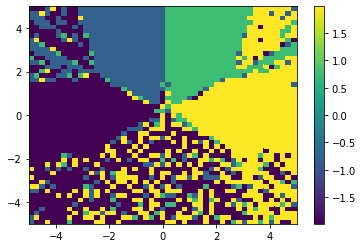

In [14]:
# visualization
import matplotlib.pyplot as plt
plt.pcolor(x, y, ans[0:noX,0:noY,0])
plt.colorbar()
plt.show()
